# Cohort Analysis

In this section, review count will be used as metric to evaluate the customer cohort

In [94]:
import sqlite3
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

## Load data

In [95]:
conn = sqlite3.connect('yelp_dataset_reviews.db') 
df_reviews= pd.read_sql("""SELECT * FROM reviews""",conn )
conn.close()

In [96]:
df_reviews.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [21]:
df_reviews.columns

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date'],
      dtype='object')

# Seasonal trends impact customer reviews

In [24]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6990280 entries, 0 to 6990279
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   review_id    object 
 1   user_id      object 
 2   business_id  object 
 3   stars        float64
 4   useful       int64  
 5   funny        int64  
 6   cool         int64  
 7   text         object 
 8   date         object 
dtypes: float64(1), int64(3), object(5)
memory usage: 480.0+ MB


In [36]:
# convert date time
df_reviews['date'] = pd.to_datetime(df_reviews['date'])
df_reviews['year'] = df_reviews['date'].dt.year
df_reviews['month'] = df_reviews['date'].dt.month
df_reviews['week'] = df_reviews['date'].dt.isocalendar().week
df_reviews['day_of_week'] = df_reviews['date'].dt.dayofweek
df_reviews.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,year,month,week,day_of_week
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,2018,7,27,5
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18,2012,1,1,1
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30,2014,2,6,2
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,2015,1,1,6
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,2017,1,2,5


In [55]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6990280 entries, 0 to 6990279
Data columns (total 13 columns):
 #   Column       Dtype         
---  ------       -----         
 0   review_id    object        
 1   user_id      object        
 2   business_id  object        
 3   stars        float64       
 4   useful       int64         
 5   funny        int64         
 6   cool         int64         
 7   text         object        
 8   date         datetime64[ns]
 9   year         int64         
 10  month        int64         
 11  week         UInt32        
 12  day_of_week  int64         
dtypes: UInt32(1), datetime64[ns](1), float64(1), int64(6), object(4)
memory usage: 673.3+ MB


In [34]:
# Group by month and year to see trends
monthly_review_count = df_reviews.groupby(['year', 'month']).size()
monthly_avg_stars = df_reviews.groupby(['year', 'month'])['stars'].mean()

In [49]:
# Resetting index to convert Series to DataFrame
monthly_review_count_df = monthly_review_count.reset_index()
monthly_avg_stars_df = monthly_avg_stars.reset_index()
monthly_review_count_df = monthly_review_count_df.rename(columns={0: 'reviewCount'})
print(monthly_review_count_df)
print(monthly_avg_stars_df)

     year  month  reviewCount
0    2005      2            3
1    2005      3           74
2    2005      4           26
3    2005      5          108
4    2005      6           38
..    ...    ...          ...
199  2021      9        46397
200  2021     10        49304
201  2021     11        45224
202  2021     12        48479
203  2022      1        31665

[204 rows x 3 columns]
     year  month     stars
0    2005      2  4.333333
1    2005      3  3.648649
2    2005      4  4.153846
3    2005      5  4.083333
4    2005      6  4.026316
..    ...    ...       ...
199  2021      9  3.615514
200  2021     10  3.654734
201  2021     11  3.675040
202  2021     12  3.673096
203  2022      1  3.704500

[204 rows x 3 columns]


In [56]:
monthly_review_count_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   year         204 non-null    int64
 1   month        204 non-null    int64
 2   reviewCount  204 non-null    int64
dtypes: int64(3)
memory usage: 4.9 KB


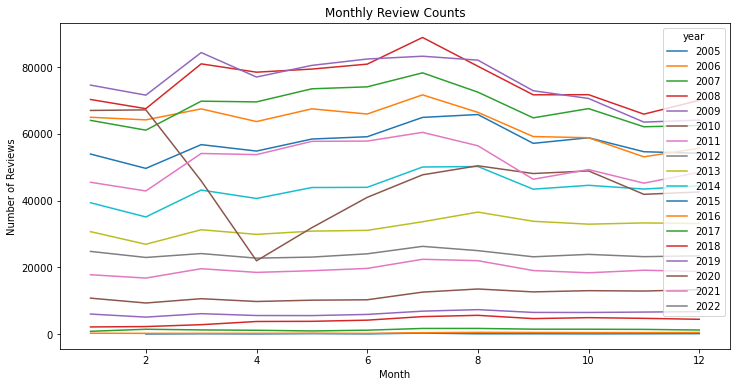

In [54]:
# Plotting Review Counts
plt.figure(figsize = (12, 6))

# Specifying x and y for plotting
sns.lineplot(x = 'month', y = 'reviewCount', hue = 'year', data = monthly_review_count_df, palette='tab10')
plt.title('Monthly Review Counts')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.show()

# Plotting Average Stars
# plt.figure(figsize = (12, 6))
# # Specifying x and y for plotting
# sns.lineplot(x = 'month', y = 'stars', hue = 'year', data = monthly_avg_stars_df, palette='tab10')
# plt.title('Monthly Average Stars')
# plt.xlabel('Month')
# plt.ylabel('Average Rating')
# plt.show()

Consistent Seasonal Trends: 

If most lines show peaks around the same months across different years, this suggests a strong seasonal trend. For instance, there's a peak every year in March/July/August/Octobor/December, this might indicate that customers are more likely to leave reviews during the holiday season. (March is spring break, July to August is summer vocation, October is autumn break and December is holiday) On the other hand, if there are consistent troughs, say in Feburary/April/November, it could imply a post-holiday slump/exams where businesses see less activity and consequently fewer reviews.

abnormal: 2010, april 

Changes in Yelp's Algorithm: Yelp's algorithm for filtering out fake reviews was said to sometimes also filter out legitimate reviews, causing frustration among businesses as positive feedback from real customers was not being displayed prominently.

Questionable Sales Tactics: Yelp's sales practices, which involved selling sponsored ads to businesses, were considered aggressive by some. 

Difficulty in Managing Online Reputation: Businesses found it challenging to manage their reputation on Yelp, as it required claiming their business page, setting up an account, and following a set of instructions to respond to comments publicly. The process was complex, and public responses that were not well-received could exacerbate negative sentiments.

Market Competition: The emergence or growth of competitor platforms might have diverted users away from Yelp.

Seasonal Behavior: April might coincide with a period where certain businesses see less activity (post-tax season, pre-summer), and hence, there might be fewer interactions to review.

User Sentiment: A change in public sentiment or trust towards Yelp due to controversy or negative press could lead to a decline in user engagement.


limitation: business type



## Model

In [61]:
monthly_review_count_df

,reviewCount
date,
2005-02-01,3
2005-03-01,74
2005-04-01,26
2005-05-01,108
2005-06-01,38
...,...
2021-09-01,46397
2021-10-01,49304
2021-11-01,45224


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# First, create a datetime index from the 'year' and 'month' columns
monthly_review_count_df['date'] = pd.to_datetime(monthly_review_count_df[['year', 'month']].assign(DAY=1))

# Set the new date column as the index
monthly_review_count_df.set_index('date', inplace=True)

# Drop the original 'year' and 'month' columns as they are no longer needed
monthly_review_count_df.drop(['year', 'month'], axis=1, inplace=True)

# Make sure the data is sorted by date
monthly_review_count_df.sort_index(inplace=True)

ADF Statistic: -1.3447110224673935
p-value: 0.6084770081328453


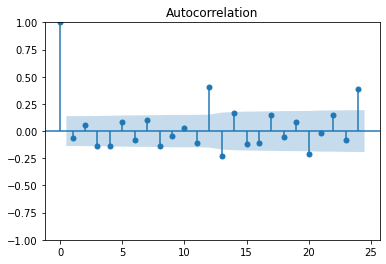

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


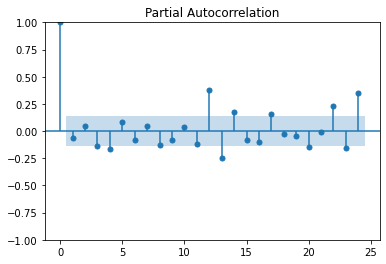

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:       reviewcount_diff   No. Observations:                  203
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1991.938
Date:                Sun, 03 Dec 2023   AIC                           3989.876
Time:                        00:43:35   BIC                           3999.801
Sample:                    03-01-2005   HQIC                          3993.891
                         - 01-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0697      0.040     -1.724      0.085      -0.149       0.010
ma.L1         -1.0000      0.057    -17.626      0.000      -1.111      -0.889
sigma2      2.102e+07   2.71e-09   7.76e+15      0.0

In [62]:
# Check if the series is stationary
from statsmodels.tsa.stattools import adfuller
result = adfuller(monthly_review_count_df['reviewCount'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# If the series is not stationary, you may need to difference it
if result[1] > 0.05:
    # Not stationary, take first difference
    monthly_review_count_df['reviewcount_diff'] = monthly_review_count_df['reviewCount'].diff().dropna()

# Check ACF and PACF plots to determine the ARIMA(p, d, q) parameters
plot_acf(monthly_review_count_df['reviewcount_diff'].dropna())
plt.show()

plot_pacf(monthly_review_count_df['reviewcount_diff'].dropna())
plt.show()

# Fit the ARIMA model
# ARIMA(1,1,1)
model = ARIMA(monthly_review_count_df['reviewcount_diff'].dropna(), order=(1, 1, 1))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Forecasting with ARIMA model
# Replace 'steps' with the number of periods you want to forecast
forecast = model_fit.forecast(steps = 12)
print(forecast)

## Popular means high-quality? 

# EDA

In [64]:
df_reviews.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,year,month,week,day_of_week
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,2018,7,27,5
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18,2012,1,1,1
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30,2014,2,6,2
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,2015,1,1,6
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,2017,1,2,5


In [84]:
# compare trending and non-trending restaurants' avg stars

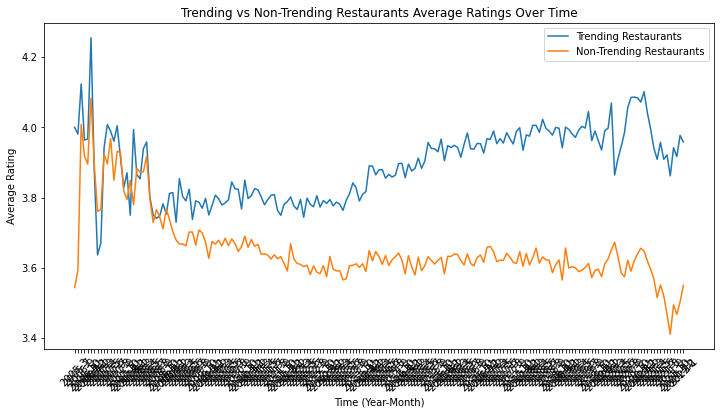

In [83]:
# Define a 'trending' threshold: top 10% of restaurants by review counts each month
threshold_percentile = 90

# Group by month, year, and business_id, and count reviews
monthly_reviews = df_reviews.groupby(['year', 'month', 'business_id']).size().reset_index(name='review_count')

# Identify trending restaurants based on the number of reviews
monthly_reviews['is_trending'] = monthly_reviews['review_count'] >= monthly_reviews.groupby(['year', 'month'])['review_count'].transform(lambda x: x.quantile(threshold_percentile / 100))

# Merge this information back to the original DataFrame
df_reviews_with_trend = pd.merge(df_reviews, monthly_reviews[['business_id', 'year', 'month', 'is_trending']], on=['business_id', 'year', 'month'])

# Calculate average ratings for trending and non-trending restaurants
trending_avg_rating = df_reviews_with_trend[df_reviews_with_trend['is_trending']].groupby(['year', 'month']).agg({'stars': 'mean'}).reset_index().rename(columns={'stars': 'avg_stars_trending'})
non_trending_avg_rating = df_reviews_with_trend[~df_reviews_with_trend['is_trending']].groupby(['year', 'month']).agg({'stars': 'mean'}).reset_index().rename(columns={'stars': 'avg_stars_non_trending'})

# Merge the average ratings for trending and non-trending for comparison
compare_ratings = pd.merge(trending_avg_rating, non_trending_avg_rating, on=['year', 'month'])

# Create a year_month column for plotting
compare_ratings['year_month'] = compare_ratings['year'].astype(str) + '-' + compare_ratings['month'].astype(str)

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(compare_ratings['year_month'], compare_ratings['avg_stars_trending'], label='Trending Restaurants')
plt.plot(compare_ratings['year_month'], compare_ratings['avg_stars_non_trending'], label='Non-Trending Restaurants')
plt.xlabel('Time (Year-Month)')
plt.ylabel('Average Rating')
plt.title('Trending vs Non-Trending Restaurants Average Ratings Over Time')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.legend()
plt.show()


                        review_count  avg_stars
business_id                                    
---kPU91CF4Lq2-WlRu9Lw            24   4.500000
--0iUa4sNDFiZFrAdIWhZQ            14   3.214286
--30_8IhuyMHbSOcNWd6DQ             9   3.555556
--7PUidqRWpRSpXebiyxTg            12   1.750000
--7jw19RH9JKXgFohspgQw            13   4.230769
...                              ...        ...
zznZqH9CiAznbkV6fXyHWA            12   4.916667
zztOG2cKm87I6Iw_tleZsQ             6   4.833333
zzu6_r3DxBJuXcjnOYVdTw             8   3.625000
zzw66H6hVjXQEt0Js3Mo4A             5   3.600000
zzyx5x0Z7xXWWvWnZFuxlQ             8   2.500000

[150346 rows x 2 columns]


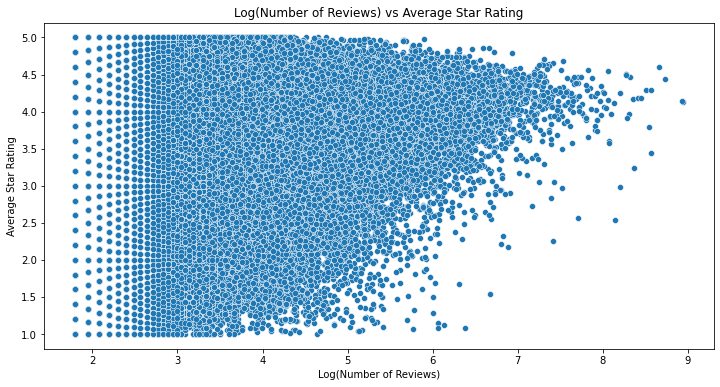

In [68]:
import statsmodels.api as sm

# Aggregate data by business
business_agg = df_reviews.groupby('business_id').agg({'review_id': 'count', 'stars': 'mean'}).rename(columns={'review_id': 'review_count', 'stars': 'avg_stars'})
print(business_agg)

# Log transformation for review count to reduce skewness
business_agg['log_review_count'] = np.log1p(business_agg['review_count'])

# Scatter Plot to visualize relationship
plt.figure(figsize=(12, 6))
sns.scatterplot(x='log_review_count', y='avg_stars', data=business_agg)
plt.title('Log(Number of Reviews) vs Average Star Rating')
plt.xlabel('Log(Number of Reviews)')
plt.ylabel('Average Star Rating')
plt.show()

In [69]:
# Correlation analysis
correlation = business_agg['log_review_count'].corr(business_agg['avg_stars'])
print(f'Correlation coefficient: {correlation}')

Correlation coefficient: 0.0511991919764926


We calculate the correlation coefficient to quantify the relationship. A correlation coefficient of approximately 0.051 suggests a very weak positive linear relationship between the logarithm of the number of reviews (popularity) and the average star rating (quality) of businesses. In practical terms, this means there is only a slight tendency for businesses with more reviews to have higher average ratings, but this trend is not strong

Trend: Look for a general trend in the scatter plot. If the points tend to go upward or downward as the log_review_count increases, it suggests a positive or negative relationship, respectively.

Clustering of Points: Notice if there are clusters of points in specific areas of the plot. This could indicate common patterns among businesses, like a common rating level regardless of review counts.

Outliers: Identify any points that stand out from the general pattern. These outliers might represent unique cases or data issues.

Density: See if there are areas where points are denser. A high density of points could indicate a common trend among many businesses.

Correlation Coefficient: The correlation value will give you a numerical measure of the relationship strength. A value close to 1 or -1 indicates a strong positive or negative correlation, respectively, while a value near 0 suggests a weak or no linear relationship.



# model

In [70]:
# Regression Analysis
X = sm.add_constant(business_agg['log_review_count'])  # Adds a constant term to the predictor
Y = business_agg['avg_stars']
model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              avg_stars   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     395.1
Date:                Sun, 03 Dec 2023   Prob (F-statistic):           8.16e-88
Time:                        01:07:21   Log-Likelihood:            -2.0728e+05
No. Observations:              150346   AIC:                         4.146e+05
Df Residuals:                  150344   BIC:                         4.146e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                3.4481      0.007  

The correlation coefficient (around 0.05) and the R-squared value (0.003) from the regression model suggest that there is only a very weak positive relationship between popularity (measured by the number of reviews) and perceived quality (measured by average star ratings).

While there is a statistically significant relationship, its practical significance is minimal. This implies that popularity, as defined by the number of reviews, is not a strong indicator of higher quality for businesses in this dataset.

In conclusion, popularity does not necessarily indicate higher quality in a meaningful way in this context.

## -------------------------

## What role does spatial data play in determining business success? 

In [9]:
conn = sqlite3.connect('yelp_dataset_business.db') 
df_business= pd.read_sql("""SELECT * FROM business""",conn )
conn.close()

In [10]:
df_business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [85]:
df_business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   150346 non-null  object 
 1   name          150346 non-null  object 
 2   address       150346 non-null  object 
 3   city          150346 non-null  object 
 4   state         150346 non-null  object 
 5   postal_code   150346 non-null  object 
 6   latitude      150346 non-null  float64
 7   longitude     150346 non-null  float64
 8   stars         150346 non-null  float64
 9   review_count  150346 non-null  int64  
 10  is_open       150346 non-null  int64  
 11  attributes    136602 non-null  object 
 12  categories    150243 non-null  object 
 13  hours         127123 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 16.1+ MB


In [86]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6990280 entries, 0 to 6990279
Data columns (total 13 columns):
 #   Column       Dtype         
---  ------       -----         
 0   review_id    object        
 1   user_id      object        
 2   business_id  object        
 3   stars        float64       
 4   useful       int64         
 5   funny        int64         
 6   cool         int64         
 7   text         object        
 8   date         datetime64[ns]
 9   year         int64         
 10  month        int64         
 11  week         UInt32        
 12  day_of_week  int64         
dtypes: UInt32(1), datetime64[ns](1), float64(1), int64(6), object(4)
memory usage: 673.3+ MB


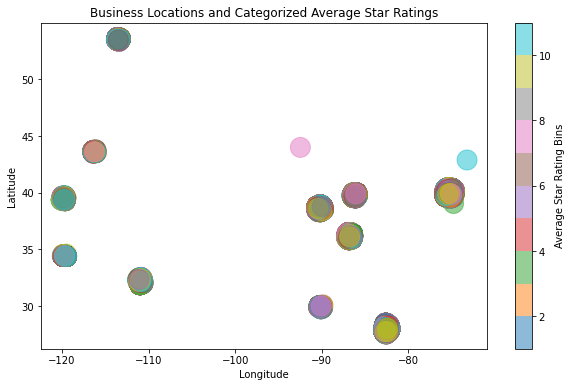

In [102]:
import numpy as np

# Categorize the average star ratings into bins
bins = np.linspace(business_data['stars'].min(), business_data['stars'].max(), 11)
business_data['star_bins'] = np.digitize(business_data['stars'], bins)

# Visualization 
plt.figure(figsize=(10, 6))
scatter = plt.scatter(business_data['longitude'], business_data['latitude'], c=business_data['star_bins'], cmap='tab10', alpha=0.5, s=400)  # s is the size of the points
plt.colorbar(scatter, label='Average Star Rating Bins')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Business Locations and Categorized Average Star Ratings')
plt.show()

The region in the United States with a longitude of approximately -70 and a latitude of approximately 43 corresponds to Portsmouth, New Hampshire, USA

-93, 45 possibly in Minnesota or a neighboring state